In [1]:
# Computations and plots
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit # Method 1 below
from scipy.signal import savgol_filter # Method 2 below

# MCMC
import corner
import emcee

%matplotlib inline
# Resolution of spectrometer: 0.5 nm

In [2]:
# Constants
from scipy import constants as cs
pi = np.pi
h = cs.h
c = cs.c
k = cs.k

# Importing dataset

The moon data is from 28/03/2023, while the sky data is from 04/04/2023. The data was collected on top of Rutherford building in Montreal with a celestron telescope and spectromer attached with a 3D custom piece. 

In [3]:
os.chdir("/Users/antoineparadis/Desktop/School/Semester4/PHYS321/PHYS321_CodingLabs2024/FinalProject")
moon_data = pd.read_csv("moon_spectra.csv")
sky_data = pd.read_csv("sky_spectra.csv")

We can then visualize the data and absorption lines of interest for both data sets

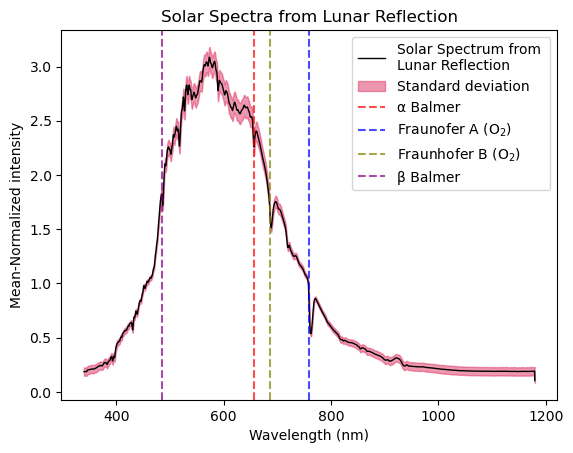

In [5]:
plt.plot(moon_data['wavelength'], moon_data['average'], linewidth = 1,
         label='Solar Spectrum from \nLunar Reflection', color = 'black')
plt.fill_between(moon_data['wavelength'], moon_data['average'] - moon_data['error']*np.sqrt(15), 
                 moon_data['average'] + moon_data['error']*np.sqrt(15),color="#DE3163",alpha=0.5,
                 label= 'Standard deviation')
plt.axvline(656.281,label = 'α Balmer',linestyle='--', color = 'red',alpha=0.7)
plt.axvline(759.370,label = 'Fraunofer A (O$_2$)',linestyle='--', color = 'blue',alpha=0.7) # earth oxygen
plt.axvline(686.719,label = 'Fraunhofer B (O$_2$)',linestyle='--', color = 'olive',alpha=0.7)
plt.axvline(486.134, label = 'β Balmer',linestyle='--',color = 'purple',alpha=0.7)
plt.title("Solar Spectra from Lunar Reflection")
plt.xlabel("Wavelength (nm)")
plt.ylabel("Mean-Normalized intensity")
plt.legend()
# plt.savefig("Spectra_Moon.pdf")

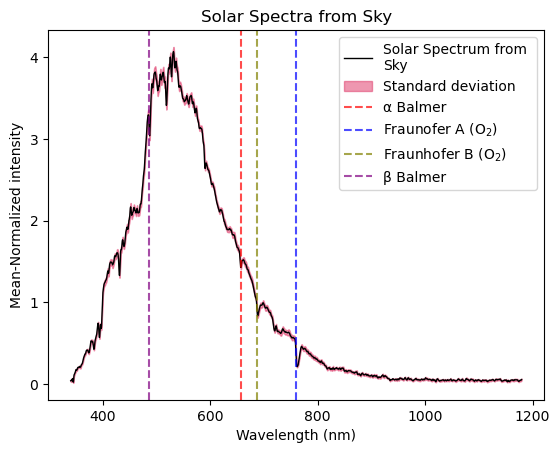

In [9]:
plt.plot(sky_data['wavelength'], sky_data['average'], linewidth = 1,
         label='Solar Spectrum from \nSky', color = 'black')
plt.fill_between(sky_data['wavelength'], sky_data['average'] - sky_data['error']*np.sqrt(15), 
                 sky_data['average'] + sky_data['error']*np.sqrt(15),color="#DE3163",alpha=0.5,
                 label= 'Standard deviation')
plt.axvline(656.281,label = 'α Balmer',linestyle='--', color = 'red',alpha=0.7)
plt.axvline(759.370,label = 'Fraunofer A (O$_2$)',linestyle='--', color = 'blue',alpha=0.7) # earth oxygen
plt.axvline(686.719,label = 'Fraunhofer B (O$_2$)',linestyle='--', color = 'olive',alpha=0.7)
plt.axvline(486.134, label = 'β Balmer',linestyle='--',color = 'purple',alpha=0.7)
plt.xlabel("Wavelength (nm)")
plt.ylabel("Mean-Normalized intensity")
plt.title("Solar Spectra from Sky")
plt.legend()
# plt.savefig("Spectra_Sky.pdf")

# Normalizing dips for MCMC fitting (Moon data)

The general idea is to obtain a smooth, fitted function to the data and then subtract it from the raw spectra in order to isolate the dips. Normal MCMC can not be applied on the absorption lines directly because of the asymmetric profile. Also, because of atmospheric loss in the spectra, it is not wise to try and fit a planck function. We therefore investigate two methods:

## 1) Fitting a lorenztian function, and then substracting this function from the data

In [10]:
def lorentz(x,a,b,c): 
    '''Computes the symmetric Lorentzian distribution with scaling
    Input:
        x (float np.array): independant variables
        a (float): mid-height width of distribution
        b (float): median/mode of distribution
        c (float): scale factor
    Output: 
        (int): value of distribution at xs
        '''
    fst = 2/(np.pi*a)
    snd = 1 + ((x-b)/(a/2))**2
    result = fst/snd
    return result*c

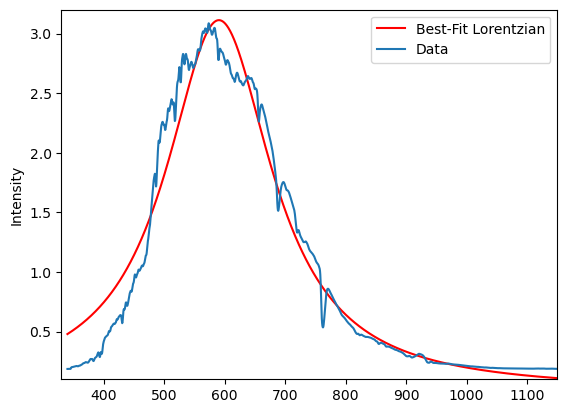

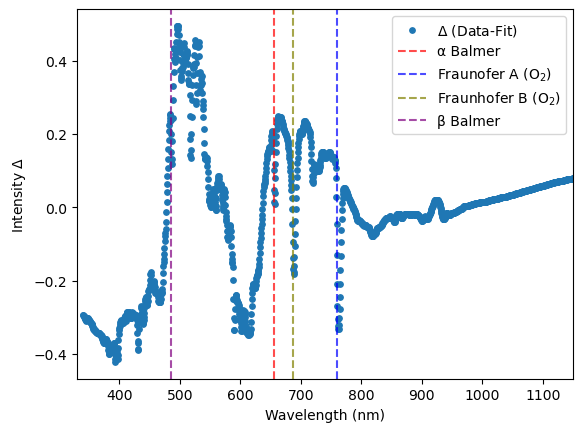

In [11]:
# Curve fitting
p0 = [200,600,100]  # Initial guess for mid-heigth width, mean, and scaling
fit_params, pcov = curve_fit(lorentz, moon_data['wavelength'],moon_data['average'], p0=p0, method='lm')

# Plot fit
fitted_data = lorentz(moon_data['wavelength'],*fit_params)
plt.plot(moon_data['wavelength'],fitted_data,label='Best-Fit Lorentzian', color = 'red')
plt.plot(moon_data['wavelength'],moon_data['average'],label='Data')
plt.xlim(330,1150)
plt.ylim(0.1,3.2)
plt.ylabel("Intensity")
plt.legend()
plt.show()

# Plot data - fit
delta = moon_data['average']-fitted_data
plt.scatter(moon_data['wavelength'],delta,marker='o', s=15,label='$\Delta$ (Data-Fit)')
plt.axvline(656.281,label = 'α Balmer',linestyle='--', color = 'red',alpha=0.7)
plt.axvline(759.370,label = 'Fraunofer A (O$_2$)',linestyle='--', color = 'blue',alpha=0.7) # earth oxygen
plt.axvline(686.719,label = 'Fraunhofer B (O$_2$)',linestyle='--', color = 'olive',alpha=0.7)
plt.axvline(486.134, label = 'β Balmer',linestyle='--',color = 'purple',alpha=0.7)
plt.xlim(330,1150)
plt.ylabel("Intensity $\Delta$")
plt.xlabel("Wavelength (nm)")
plt.legend()
plt.show()

**Note: All absorption lines are indentifiable (and noticeably not noise) except for the β Balmer line**

# 2. Obtain a smoothed curve and the substracting this from the data (using the Savitzky-Golay filter)

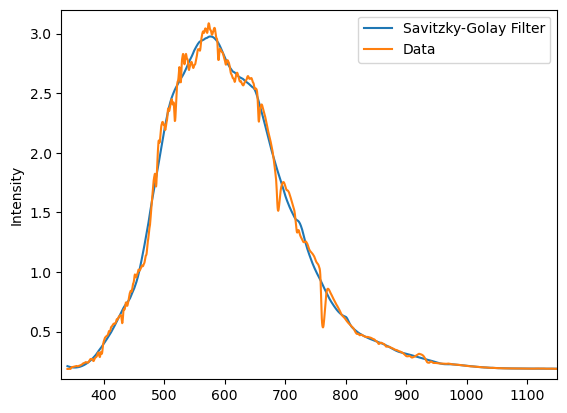

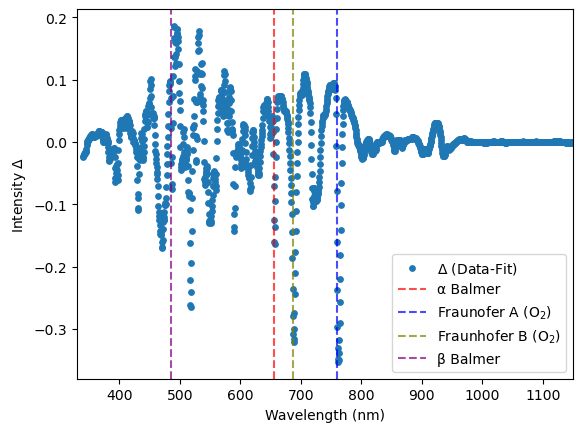

In [12]:
# Apply Savitzky-Golay filter, 167 window size (10 windows in 1680 total data points), second order polynomial fit 
smoothed_y = savgol_filter(moon_data['average'], window_length=167, polyorder=2) 
plt.plot(moon_data['wavelength'],smoothed_y,label="Savitzky-Golay Filter")
plt.plot(moon_data['wavelength'],moon_data['average'],label="Data")
plt.xlim(330,1150)
plt.ylim(0.1,3.2)
plt.ylabel("Intensity")
plt.legend()
plt.show() 

# Plot data - smooth
delta2 = moon_data['average']-smoothed_y
plt.scatter(moon_data['wavelength'],delta2,label='$\Delta$ (Data-Fit)',marker='o', s=15)
plt.axvline(656.281,label = 'α Balmer',linestyle='--', color = 'red',alpha=0.7)
plt.axvline(759.370,label = 'Fraunofer A (O$_2$)',linestyle='--', color = 'blue',alpha=0.7) # earth oxygen
plt.axvline(686.719,label = 'Fraunhofer B (O$_2$)',linestyle='--', color = 'olive',alpha=0.7)
plt.axvline(486.134, label = 'β Balmer',linestyle='--',color = 'purple',alpha=0.7)
plt.ylabel("Intensity $\Delta$")
plt.xlabel("Wavelength (nm)")
plt.xlim(330,1150)
plt.legend()
plt.show()

**Note: Absorption lines are more prominent using this method, but the β Balmer line is still much too noisy to be fit for**

# Balmer $\alpha$ (H, n=3 -> n=2)

We can compare all three absorption features, and see that the smoothing out method provides the clearest valley to fit for with MCMC (although similar to method 1). Note that 8 data points are included on the both sides of the minimum value.

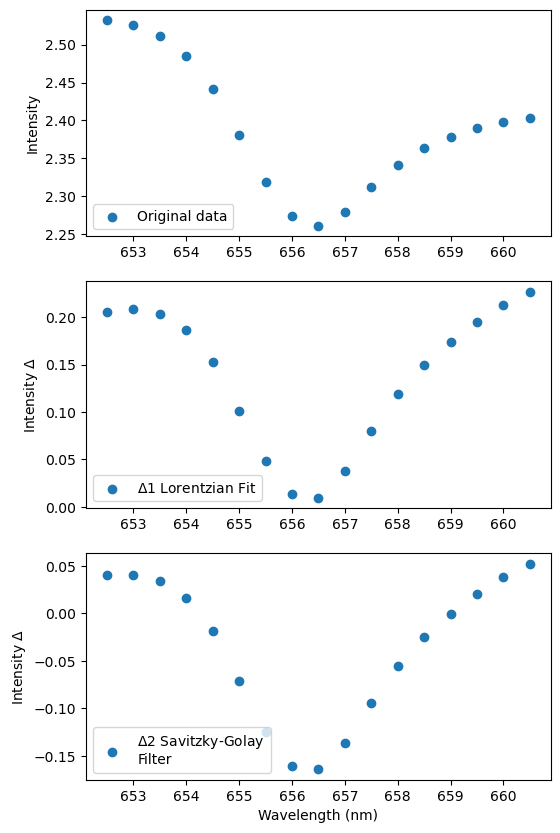

In [13]:
fig, axs = plt.subplots(3, 1, figsize=(6, 10))  # 3 subplots vertically arranged

# Plot moon_data on the first subplot
axs[0].scatter(moon_data['wavelength'][625:642], moon_data['average'][625:642], label='Original data')
axs[0].set_ylabel("Intensity")
axs[0].legend(loc='lower left')

# Plot delta on the second subplot
axs[1].scatter(moon_data['wavelength'][625:642], delta[625:642], label='$\Delta$1 Lorentzian Fit')
axs[1].set_ylabel("Intensity $\Delta$")
axs[1].legend(loc='lower left')
axs[1].legend()

# Plot delta2 on the third subplot
axs[2].scatter(moon_data['wavelength'][625:642], delta2[625:642], label='$\Delta$2 Savitzky-Golay \nFilter')
axs[2].set_xlabel("Wavelength (nm)")
axs[2].set_ylabel("Intensity $\Delta$")
axs[2].legend(loc='lower left')
# plt.savefig("Feature_Correction_Balmer_Moon.pdf")
plt.show()

## Specific plots for paper

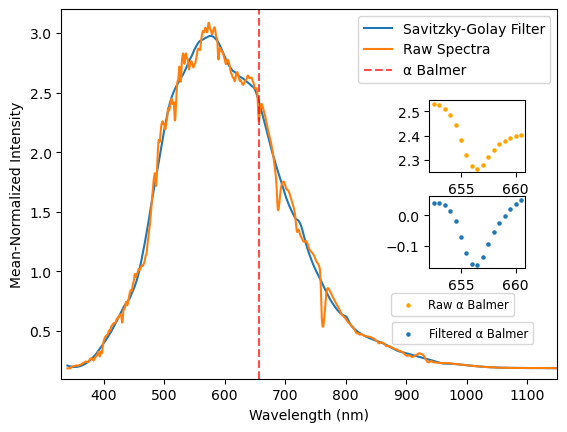

In [14]:
# Create a plot embedding for paper

fig, ax_main = plt.subplots()

smoothed_y = savgol_filter(moon_data['average'], window_length=167, polyorder=2) 
ax_main.plot(moon_data['wavelength'],smoothed_y,label="Savitzky-Golay Filter")
ax_main.plot(moon_data['wavelength'],moon_data['average'],label="Raw Spectra")
ax_main.axvline(656.281,label = 'α Balmer',linestyle='--', color = 'red',alpha=0.7)
ax_main.set_xlim(330,1150)
ax_main.set_ylim(0.1,3.2)
ax_main.set_ylabel("Mean-Normalized Intensity")
ax_main.set_xlabel("Wavelength (nm)")

# add the imbedded plots
left, bottom, width, height = [0.7, 0.54, 0.15, 0.15]
ax_inset = fig.add_axes([left, bottom, width, height])
left2, bottom2, width2, height2 = [0.7, 0.34, 0.15, 0.15]
ax_inset2 = fig.add_axes([left2, bottom2, width2, height2])


# Plot the inset data
ax_inset.scatter(moon_data['wavelength'][625:642], moon_data['average'][625:642], label='Raw α Balmer',s=5,color="orange")
ax_inset.legend(fontsize = 'small',bbox_to_anchor=(0.841, 0.30), bbox_transform=plt.gcf().transFigure)

ax_inset2.scatter(moon_data['wavelength'][625:642], delta2[625:642],label='Filtered α Balmer',s=5)
ax_inset2.legend(fontsize = 'small',bbox_to_anchor=(0.871, 0.24), bbox_transform=plt.gcf().transFigure)
ax_main.legend()
# plt.savefig("Filter+Spectra_Balmer_Moon.pdf")

plt.show()

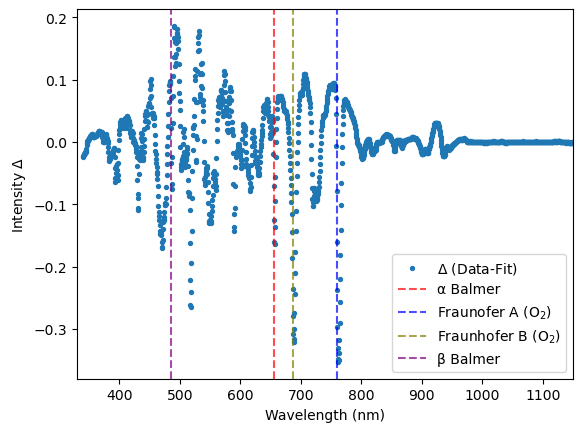

In [15]:
# Plot data - smooth
delta2 = moon_data['average']-smoothed_y
plt.scatter(moon_data['wavelength'],delta2,label='$\Delta$ (Data-Fit)',marker='o', s=8)
plt.axvline(656.281,label = 'α Balmer',linestyle='--', color = 'red',alpha=0.7)
plt.axvline(759.370,label = 'Fraunofer A (O$_2$)',linestyle='--', color = 'blue',alpha=0.7) # earth oxygen
plt.axvline(686.719,label = 'Fraunhofer B (O$_2$)',linestyle='--', color = 'olive',alpha=0.7)
plt.axvline(486.134, label = 'β Balmer',linestyle='--',color = 'purple',alpha=0.7)
plt.ylabel("Intensity $\Delta$")
plt.xlabel("Wavelength (nm)")
plt.xlim(330,1150)
plt.legend()
# plt.savefig("Filtered_WholeSpectra_Moon.pdf")
plt.show()

We are now ready to run MCMC with an inverse lorentztian to fit. First, we define the necessary functions

In [16]:
def inv_lorentz(x,params):
    '''Inverse lorentzian function with offset parameter
    Input:
        x (float np.array): independant variables
        params (float np.array): 
            a -> midheigth width of distribution
            b -> median/mode of distribution
            c -> y-axis offset
    Output:
         (float np.array) : value of distribution at xs'''
    a,b,c = params
    fst = 2/(np.pi*a)
    snd = 1 + ((x-b)/(a/2))**2
    return c-(fst/snd)
  

def log_likelihood(params,x,y,yerr):
    '''
    Models the absorption dips with a lorentzian distribution,
    assuming normally distributed errors
    Input:
        params (float np.array): model parameters
        x (float np.array): wavelength data
        y (float np.array): mean-normalized intensity
        yerr (float np.array): mean-normalized intensity error
    Returns:
        like (float np.array): log likelihood of data given params
    '''
    
    model=inv_lorentz(x,params)
    sigma2 = yerr**2
    like = -0.5 * np.sum((y - model) ** 2 / sigma2 + np.log(sigma2))
    return like


def log_prior(params):
    '''
    Prior knowledge of wavelength bounds and midheigth width
    Input:
        params (float np.array): model parameters
    Returns: 
        (float): 0 if params in bounds
        (float): -inf if params out of bounds
    '''
    a,b,c = params
    if 0 < a < 5 and 650. < b < 660. and -1 < c < 1: # from looking at data
        return 0.0 
    return -np.inf # log(0) = -inf

def log_posterior(params, x, y, yerr):
    '''
    Combines log_likelihood and log_prior to give log_posterior probability of params given data 
    Input:
        params (float np.array): model paramaters
        x (float np.array): wavelength data
        y (float np.array): mean-normalized intensity 
        yerr (float np.array): mean-normalized intensity error 
    Returns:
        (float) : -inf if a,b out of bounds
        (float np.array) : else log_posterior of params given data
    '''
    lp = log_prior(params)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(params, x, y, yerr)

Next, we define initial conditions, create walkers, run the MCMC algorithm, and plot the results in different ways.

In [17]:
# Initial conditions (this cell takes long too run)

# Data (choose delta2, i.e smoothing out method)
y_balmer = delta2[625:642]
x_balmer = moon_data['wavelength'][625:642]
err_balmer = moon_data['error'][625:642]

ndi = 3  # number of parameters in the model
nw = 32  # number of MCMC walkers
nst = 5000  # number of MCMC steps to take

# Set initial params guesses and add some small fluctuation for all walkers 
para_guesses = np.zeros((nw, ndi))
para_guesses[:, 0] =  2.5 # mid-heigth width (a)
para_guesses[:, 1] =  656 # initial wavelength value (b)
para_guesses[:, 2] =  0.05 # offset (c)
para_guesses += 0.01 * np.random.rand(nw, ndi) # random variations for the 32 walkers to start off

# Run MCMC and get flattened chain
balmer_moon_sample = emcee.EnsembleSampler(nw, ndi, log_posterior, args=[x_balmer,y_balmer,err_balmer])
balmer_moon_sample.run_mcmc(para_guesses, nst, progress = True)
flat_samples1 = balmer_moon_sample.get_chain(discard=500, thin=20, flat=True)

100%|███████████████████████████████████████| 5000/5000 [03:31<00:00, 23.69it/s]


Text(0.5, 0, 'Step number')

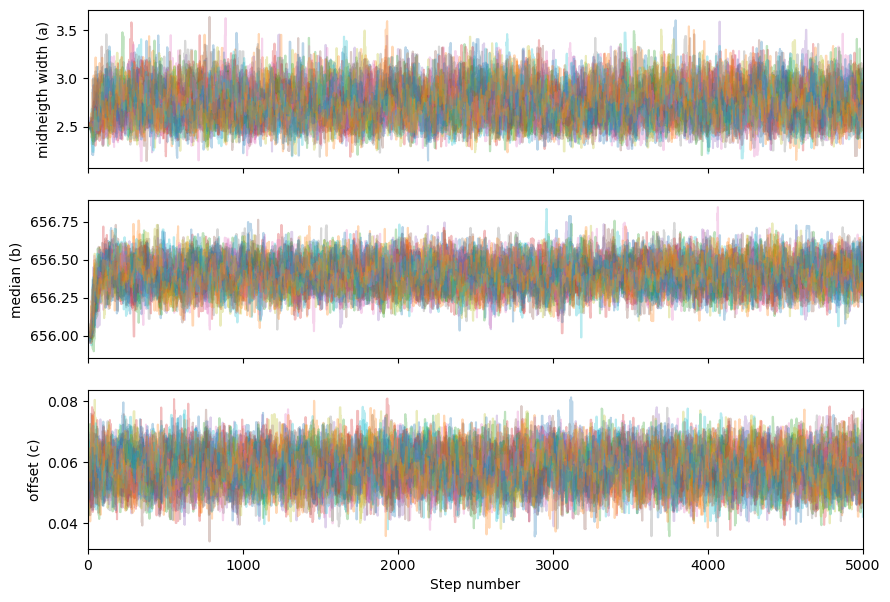

In [18]:
# Take a look at the walkers, i.e if they explore parameter space well or get stuck

f, axes = plt.subplots(3, figsize=(10, 7), sharex=True)
samples = balmer_moon_sample.get_chain()
labels = ["midheigth width (a)", "median (b)","offset (c)"]
for i in range(ndi):
    ax = axes[i]
    ax.plot(samples[:, :,i], alpha=0.3) # all walkers for parameter i
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])

axes[-1].set_xlabel("Step number")
# plt.savefig("Walkers_Moon_Balmer.pdf")

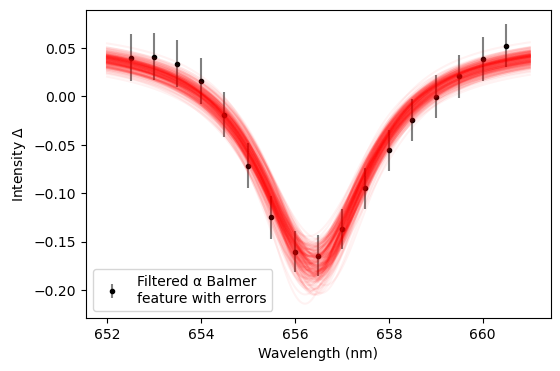

In [20]:
# Plot real data
f, ax = plt.subplots(figsize=(6,4))
ax.errorbar(x_balmer, y_balmer, yerr=err_balmer, fmt='.k', ecolor='gray', zorder = 1,label="Filtered α Balmer\nfeature with errors")
ax.set_ylabel("Intensity $\Delta$")
ax.set_xlabel("Wavelength (nm)")

# Plot interpolated data with randomly picked parameter sets from MCMC chain
index = np.random.randint(len(flat_samples1), size=200)
x_fit = np.linspace(652,661,1000)

# Plot some parameter sets (fits)
for ind in index:
    sample_params = flat_samples1[ind]
    ax.plot(x_fit, inv_lorentz(x_fit, sample_params), alpha=0.05, color='red', zorder = 3)
plt.legend()
# plt.savefig("Balmer_MCMCfit_Moon.pdf")
plt.show()

Quantiles:
[(0.16, 2.56676627505136), (0.5, 2.730904199865561), (0.84, 2.9137310183898832)]
Quantiles:
[(0.16, 656.3103574408956), (0.5, 656.4022627561063), (0.84, 656.4935361971583)]
Quantiles:
[(0.16, 0.05244717770729805), (0.5, 0.058008360959400915), (0.84, 0.0637920374690438)]


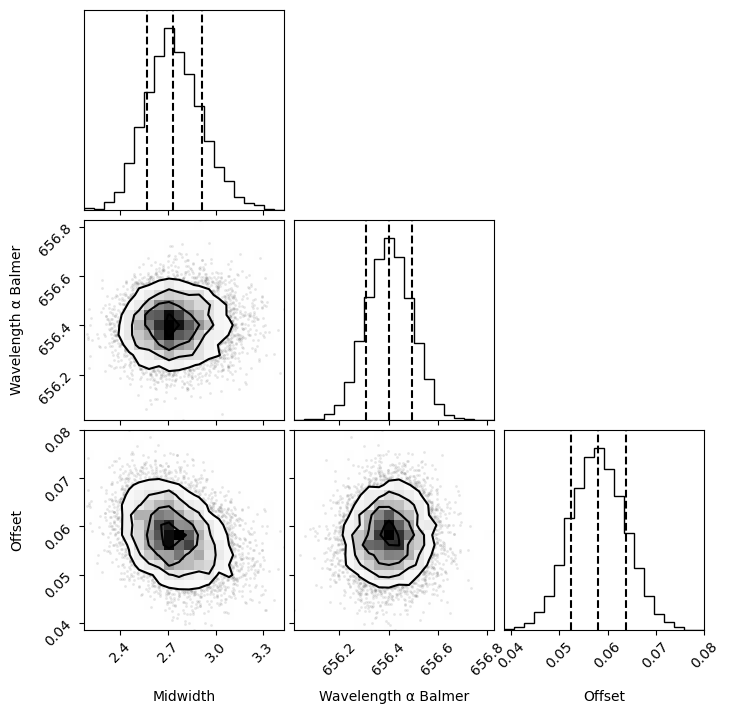

In [21]:
# Corner plot of parameters, with 68% (1 std) region shown between vertical lines and outputed
labels = ["Midwidth","Wavelength α Balmer","Offset"]
fig = corner.corner(flat_samples1,labels=labels,quantiles=[0.16,0.5,0.84],plot_contours=True,verbose=True)
# plt.savefig("Corner_Plot_Moon_Balmer.pdf")

In [22]:
# Retrieve fit value of balmer absorption line
balmer_w = np.mean(samples[:, :,1])
balmer_w_err = np.std(samples[:, :,1])

print("Note that parameter sets are relatively constrained, as seen in corner plot")
print("Wavelength α balmer fit: ", round(balmer_w,3),"+-",round(balmer_w_err,3))

Note that parameter sets are relatively constrained, as seen in corner plot
Wavelength α balmer fit:  656.399 +- 0.098
